In [1]:
from fastbook import *

In [2]:
urls = search_images_ddg('teddy photos', max_images=1)
len(urls), urls[0]

(1, 'https://wallsdesk.com/wp-content/uploads/2016/11/Teddy-Bear-Pictures.jpg')

In [3]:
dest = Path('teddy.jpg')
if not dest.exists(): download_url(urls[0], dest)

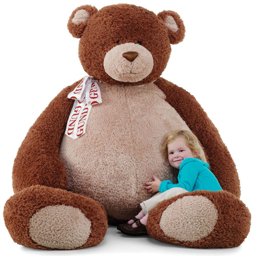

In [4]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [7]:
import os
from pathlib import Path
from urllib.parse import urlparse
import requests

In [8]:
def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

In [11]:
def is_image_url(url):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    return any(url.lower().endswith(ext) for ext in image_extensions)

In [9]:
def is_image_by_head_request(url):
    try:
        response = requests.head(url, timeout=5)
        content_type = response.headers.get('Content-Type', '')
        return content_type.startswith('image/')
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return False

In [60]:
def download_images(bear_type, dest, max_images=5):
    downloaded_images = 0
    page = 0  # Pagination, assuming your search function supports it
    
    while downloaded_images < max_images:
        results = search_images_ddg(f'{bear_type} bear', max_images=max_images, page=page)
        
        if not results:
            print(f"No results found for {bear_type} bear.")
            break
        
        for url in results:
            if downloaded_images >= max_images:
                break
            
            if is_valid_url(url) and is_image_url(url) and is_image_by_head_request(url):
                try:
                    # Pobierz obraz
                    image_data = requests.get(url).content
                    image_path = dest / f'{bear_type}_bear_{downloaded_images + 1}.jpg'
                    with open(image_path, 'wb') as f:
                        f.write(image_data)
                    print(f"Saved {bear_type}_bear_{downloaded_images + 1}.jpg to {dest}")
                    downloaded_images += 1
                except Exception as e:
                    print(f"Failed to download image from {url}: {e}")
            else:
                print(f"Skipping invalid or non-image URL: {url}")
        
        page += 1  # Increment page number to fetch more results if necessary


In [62]:
def download_images(bear_type, dest, max_images=5):
    downloaded_images = 0
    total_attempted_images = 0
    
    while downloaded_images < max_images:
        remaining_images = max_images - downloaded_images
        results = search_images_ddg(f'{bear_type} bear', max_images=remaining_images)
        
        if not results:
            print(f"No more results found for {bear_type} bear.")
            break
        
        for url in results:
            total_attempted_images += 1
            if downloaded_images >= max_images:
                break
            
            if is_valid_url(url) and is_image_url(url) and is_image_by_head_request(url):
                try:
                    image_data = requests.get(url).content
                    image_path = dest / f'{bear_type}_bear_{downloaded_images + 1}.jpg'
                    with open(image_path, 'wb') as f:
                        f.write(image_data)
                    print(f"Saved {bear_type}_bear_{downloaded_images + 1}.jpg to {dest}")
                    downloaded_images += 1
                except Exception as e:
                    print(f"Failed to download image from {url}: {e}")
            else:
                print(f"Skipping invalid or non-image URL: {url}")
        
        if downloaded_images < max_images:
            print(f"Attempted to download {total_attempted_images} images but only {downloaded_images} were valid. Retrying...")

In [63]:
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()

for bear in bear_types:
    dest = path / bear
    dest.mkdir(exist_ok=True)
    download_images(bear, dest, max_images=150)

Saved grizzly_bear_1.jpg to bears/grizzly
Saved grizzly_bear_2.jpg to bears/grizzly
Saved grizzly_bear_3.jpg to bears/grizzly
Saved grizzly_bear_4.jpg to bears/grizzly
Saved grizzly_bear_5.jpg to bears/grizzly
Skipping invalid or non-image URL: http://alaskagirlatheart.com/wp-content/uploads/2012/05/grizzly-1.jpg
Saved grizzly_bear_6.jpg to bears/grizzly
Saved grizzly_bear_7.jpg to bears/grizzly
Saved grizzly_bear_8.jpg to bears/grizzly
Saved grizzly_bear_9.jpg to bears/grizzly
Saved grizzly_bear_10.jpg to bears/grizzly
Skipping invalid or non-image URL: https://i1.wp.com/blog.gaiagps.com/wp-content/uploads/2020/10/Mangelsen-3306-1.jpg?fit=2000%2C1333&ssl=1
Skipping invalid or non-image URL: http://media-cache-ec0.pinimg.com/736x/f5/70/78/f57078fcba2ae097645d094cc44496a5.jpg
Saved grizzly_bear_11.jpg to bears/grizzly
Saved grizzly_bear_12.jpg to bears/grizzly
Saved grizzly_bear_13.jpg to bears/grizzly
Skipping invalid or non-image URL: https://www.gannett-cdn.com/-mm-/7e482a443740f5233

In [64]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [65]:
dls = bears.dataloaders(path, bs=5)

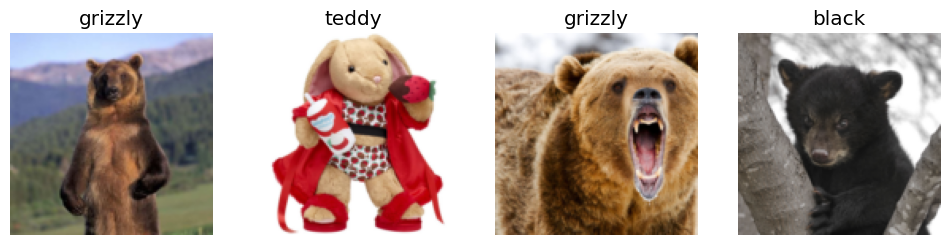

In [66]:
dls.train.show_batch(max_n=4, nrows=1)


In [67]:
print(len(dls.valid_ds))


90


In [68]:
batch = dls.valid.one_batch()
print(len(batch[1]))


5


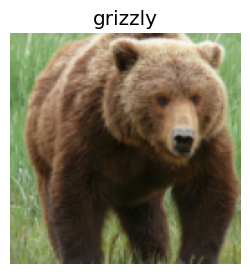

In [69]:
dls.valid.show_batch(max_n=1)


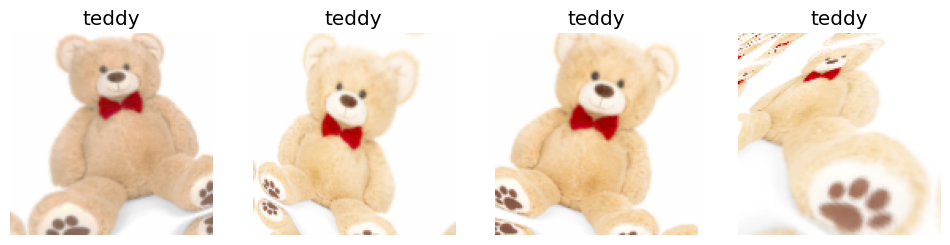

In [70]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # type: ignore
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [71]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.235459,0.307573,0.111111,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.370393,0.060688,0.011111,00:24
1,0.303455,0.038965,0.022222,00:25
2,0.253504,0.025886,0.011111,00:25
3,0.227311,0.030433,0.022222,00:28


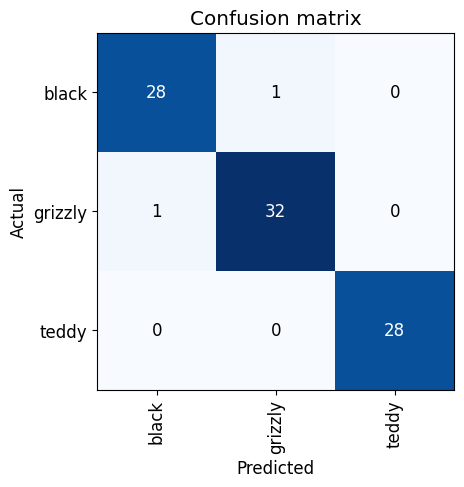

In [72]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

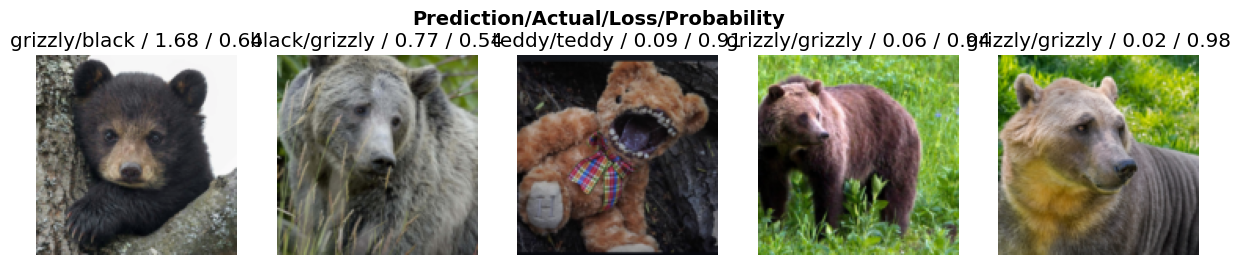

In [73]:
interp.plot_top_losses(5, nrows=1)

In [83]:
learn.export()

In [84]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [85]:
learn_inf = load_learner(path/'export.pkl')

In [86]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [87]:
img = PILImage.create(btn_upload.data[-1])

In [88]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [89]:
from fastai.vision.widgets import *

In [90]:
pred,pred_idx,probs = learn_inf.predict(img)

In [91]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 1.0000')